<h1><center>Handwritten Math Symbols Classification</center></h1>
<center>by Chao Xu</center>

<h3>I: Introduction</h3>

This project is aimed to classify handwritten math symbols based on the dataset on Kaggle. The contributor of the dataset created a new one similar to MNIST but with higher resolution and also added other math symbols such as +, -, and x, y, z.

Dataset:
<b>Handwritten Math Symbols</b> (https://www.kaggle.com/datasets/sagyamthapa/handwritten-math-symbols)

With this dataset, I will use different deep learning techniques to build two different models. The main steps are as follows:
- Split data into different folders and load data using <i>tf.data.Dataset API.</i>
- Analyze and preprocess the data to prepare for the training.
- Use AlexNet Architecture and Keras Tuner to build a model by tuning learning rate and activation function. 
- Use pre-trained model (VGGNet19) to build another model to see which one performs better.
- Use the better model to evaluate the performance with confusion matrix and classification report.
- Save the final model and test it with my own handwritten images.

<h3>II: Load, Preprocess, and Analyzing Data</h3>

<h4>Import libraries for loading, analyzing, and preprosessing data</h4>

In [1]:
#Import libraries for loading, analyzing, and preprosessing data
import numpy as np
import os
import cv2
import tensorflow as tf
from matplotlib import pyplot as plt

In [2]:
#Make sure the GPU is availabe 
gpus = tf.config.list_physical_devices('GPU')
print("Num GPUs Available: ", len(gpus))

Num GPUs Available:  1


In [3]:
#Limit the GPU memory growth so that the runtime initialization will not allocate all GPU memory on the device.
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

<h4>Splitting data into train and test folders</h4>

In [4]:
#Set the path of the data folder
path = 'Data'

In [5]:
#Split the data into train and test
#!pip install split-folders
import splitfolders
splitfolders.ratio(path, output="Splitted_Data", seed=1001, ratio=(0.9, 0, 0.1)) 

Copying files: 10071 files [00:08, 1205.09 files/s]


In [6]:
#Create path for the train and test folder
train_directory = 'Splitted_Data/train'
test_directory = 'Splitted_Data/test'

<h4>Generate tf.data.Dataset (Loading data)</h4>

In [7]:
#Generates tf.data.Dataset from image files in the train and test directory.
train, val = tf.keras.utils.image_dataset_from_directory(
    train_directory, label_mode='categorical', 
    validation_split=0.25, subset='both', shuffle=True,
    image_size=(224, 224), seed=1001, batch_size=64)

test = tf.keras.utils.image_dataset_from_directory(
    test_directory, label_mode='categorical', shuffle=False,
    image_size=(224, 224), seed=1001, batch_size=64)

Found 9053 files belonging to 19 classes.
Using 6790 files for training.
Using 2263 files for validation.
Found 1018 files belonging to 19 classes.


- I set the image size to (224, 224) to match the input shape of cnn model.
- By default, the image_dataset_from_directory function set batch size to 32. I increased the batch size to 64. 
- I split 25% of the data in train folder as validation.
- For the consistency, the shuffle in the test data is set to False.

<h4>Analyzing Data</h4>

Now it's time to check the images and labels.

In [8]:
#Use as_numpy_iterator to inspect the content of the dataset
train_iterator = train.as_numpy_iterator()

#Use next() to grab batches from the dataset
batch = train_iterator.next()

#Show the shape of train data in a batch
print('The length of the batch:', len(batch))
print('The shape of the images in the batch:', batch[0].shape)
print('The shape of the labels in the batch:', batch[1].shape)
print('The sample label data:', batch[1][0])

The length of the batch: 2
The shape of the images in the batch: (64, 224, 224, 3)
The shape of the labels in the batch: (64, 19)
The sample label data: [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


- The length of the batch is 2, which means for each element, there is a image and a corresponding label.
- The number 64 represents the batch size.
- The shape of the images (64, 224, 224, 3) represents the batch size, image size, and 3 channel. 
- The shape of the labels (64, 19) represents the batch size and 19 categories as labels.
- The sample label data shows that it is a one-hot encoding format.

<h4>Put the image labels in a list</h4>

In [9]:
#Put the image labels in a list
labels = [f for f in os.listdir(path) if os.path.isdir(os.path.join(path, f))]
n_classes = len(labels)

print('There are', n_classes, 'classes in this dataset.')
print('The classes are:', labels)

There are 19 classes in this dataset.
The classes are: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'add', 'dec', 'div', 'eq', 'mul', 'sub', 'x', 'y', 'z']


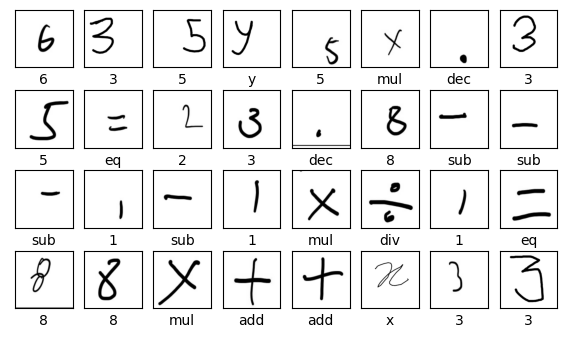

In [10]:
#Show some images with their labels in one train batch
plt.figure(figsize=(7,4))

for k in range(32):
    plt.subplot(4,8,k+1)
    ax = plt.gca()
    ax.set_xticks([])
    ax.set_yticks([])
    plt.imshow(batch[0][k].astype(int), cmap=plt.cm.gray)
    #Get the index of the maximum value (1) and change it to the actual label name
    plt.xlabel(labels[batch[1][k].argmax()], fontsize=10)

plt.show()

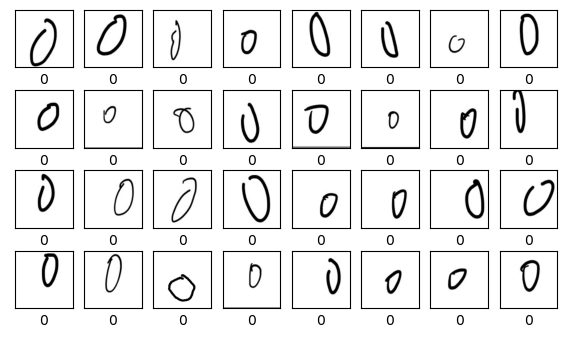

In [11]:
#Show images with their labels in one test batch
test_iterator = test.as_numpy_iterator()
test_batch = test_iterator.next()

plt.figure(figsize=(7,4))

for k in range(32):
    plt.subplot(4,8,k+1)
    ax = plt.gca()
    ax.set_xticks([])
    ax.set_yticks([])
    plt.imshow(test_batch[0][k].astype(int), cmap=plt.cm.gray)
    #Get the index of the maximum value (1) and change it to the actual label name
    plt.xlabel(labels[test_batch[1][k].argmax()], fontsize=10)

plt.show()

We can see besides numbers (0-9), there are other operators such as plus, minus, multiplication, division, decimal point, and equal sign. Both images in the train set and the test set match with their label correctly. (The images from test show only 0 because the data in the test folder is not shuffled.)

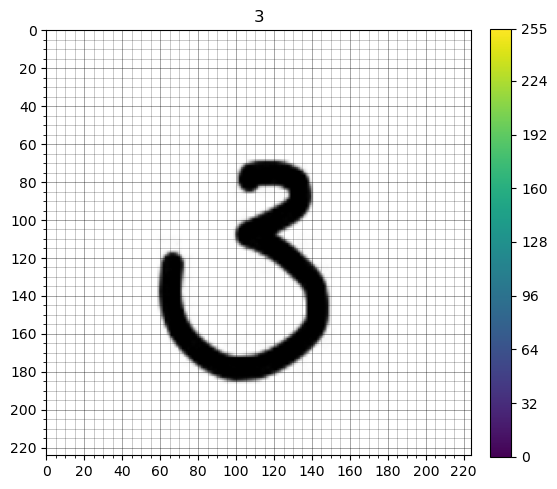

In [101]:
#Plot one sample image from training set
sample = np.random.randint(0,32)
plt.figure(figsize = (6,6))
sample_img = batch[0][sample]
plt.imshow(sample_img.astype("uint8"))
ax = plt.gca()
plt.title(labels[batch[1][sample].argmax()])

# Set major ticks every 5, minor ticks every 1
major_ticks = np.arange(0, 225, 20)
minor_ticks = np.arange(0, 225, 5)

ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
ax.set_yticks(major_ticks, )
ax.set_yticks(minor_ticks, minor=True)

#Set view limits of both axes to hide extra lines
ax.set_xlim(0, 224)
ax.set_ylim(224, 0)

#Set different alpha for the grids:
ax.grid(which='minor', alpha=0.3, linewidth=0.5, color='black')
ax.grid(which='major', alpha=0.5, linewidth=0.5, color='black')

#Show the color bar
_ = plt.colorbar(fraction=0.046, pad=0.04, ticks=[0,32,64,96,128,160,192,224,255])

plt.show()

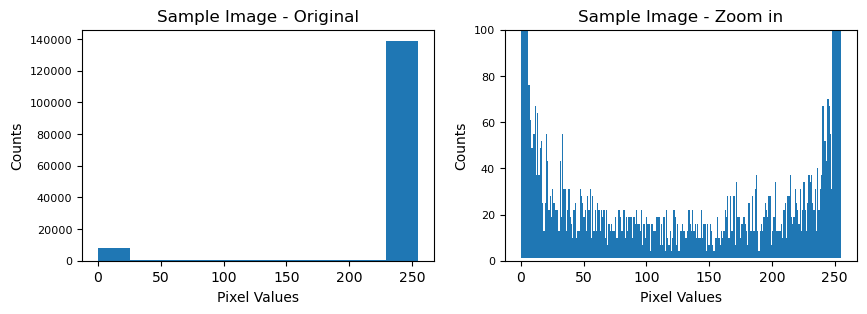

In [102]:
#Also plot the histogram of this image.
fig, axes = plt.subplots(ncols=2, figsize=(10,3))

axes[0].hist(sample_img.ravel())
axes[0].set_title('Sample Image - Original')
axes[0].set_xlabel('Pixel Values')
axes[0].set_ylabel('Counts')

axes[1].hist(sample_img.ravel(), bins=256, bottom=1)
axes[1].set_ylim([0, 100])
axes[1].set_xlabel('Pixel Values')
axes[1].set_ylabel('Counts')
axes[1].set_title('Sample Image - Zoom in')

axes[0].yaxis.set_tick_params(labelsize=8)
axes[1].yaxis.set_tick_params(labelsize=8)

plt.show()

Since the image is a handwritten symbol with white background, most of the color is white (255), and some of the color is black (0). There is not too much other color in between.

<h4>Preprocess data</h4>

Convert pixel numbers to 0-1 instead of 0-255. 

In [14]:
train = train.map(lambda X, y: (X/255, y))
val = val.map(lambda X, y: (X/255, y))
test = test.map(lambda X, y: (X/255, y))

In [15]:
#Check the data to see if the data is transformed correctly.

scaled_train_batch = train.as_numpy_iterator().next()
print('The maximum pixel value of images in the train set is:', scaled_train_batch[0].max())
scaled_val_batch = val.as_numpy_iterator().next()
print('The maximum pixel value of images in the validation set is:', scaled_val_batch[0].max())  
scaled_test_batch = test.as_numpy_iterator().next()
print('The maximum pixel value of images in the test set is:', scaled_test_batch[0].max())  

The maximum pixel value of images in the train set is: 1.0
The maximum pixel value of images in the validation set is: 1.0
The maximum pixel value of images in the test set is: 1.0


The dataset is transformed correctly.

<h3>III: Build a model using AlexNet Architecture and Keras Tuner</h3>

For this section, I want to use AlexNet Architecture and Keras Tuner to find the best activation function for dense layers, the best learning rate for the optmizer Adam, and train the model using more epochs with early stopping.

In [16]:
#Import libraries for creating cnn model and hyperparameter tuning
import keras
import keras_tuner as kt
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, BatchNormalization

In [17]:
#Delete any logs from a previous run
import shutil

# shutil module is part of the Python standard library and provides a 
# collection of utility functions for working with files and directories. 

folder_path = "my_dir/math_symbols/"

# Check if the folder exists before attempting to delete it
if os.path.exists(folder_path):
    # Remove the folder and its contents recursively
    shutil.rmtree(folder_path)
    print(f"The folder '{folder_path}' has been deleted.")
else:
    print(f"The folder '{folder_path}' does not exist.")

The folder 'my_dir/math_symbols/' does not exist.


<h4>Define the model</h4>

In [18]:
#Define the model
def model_builder(hp):
    model = Sequential()
    model.add(Conv2D(96, kernel_size=(11, 11), strides=(4, 4), 
                     activation='relu', input_shape=(224, 224, 3)))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
    model.add(BatchNormalization())

    # second conv-pool block
    model.add(Conv2D(256, kernel_size=(5, 5), activation='relu'))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
    model.add(BatchNormalization())

    # third conv-pool block
    model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
    model.add(Conv2D(384, kernel_size=(3, 3), activation='relu'))
    model.add(Conv2D(384, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
    model.add(BatchNormalization())

    # dense layers
    model.add(Flatten())
    #Tune the activation function for dense layers
    actfun = hp.Choice('activation', values=['relu', 'tanh'])
    model.add(Dense(4096, activation=actfun))
    model.add(Dropout(0.5))
    model.add(Dense(4096, activation=actfun))
    model.add(Dropout(0.5))

    # output layer
    model.add(Dense(19, activation='softmax'))   
    
    #Tune the learning rate for the optimizer
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4, 1e-5])
    model.compile(loss='categorical_crossentropy', 
                  optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate), 
                  metrics=['accuracy'])
    
    return model

<h4>Instantiate the tuner and perform hypertuning</h4>

In [19]:
tuner = kt.Hyperband(model_builder, objective='val_accuracy', 
                     max_epochs=100, factor=3, directory='my_dir', 
                     project_name='math_symbols')

<h4>Start tuning using tuner.search()</h4>

In [20]:
#Create a variable stop_early for callbacks with EarlyStopping
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [21]:
tuner.search(train, epochs=50, batch_size=64, validation_data=val, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
The hyperparameter search is complete. The optimal activation function is '{best_hps.get('activation')}'.
The optimal optimizer learning rate is {best_hps.get('learning_rate')}.
""")

Trial 8 Complete [00h 00m 09s]
val_accuracy: 0.05523641034960747

Best val_accuracy So Far: 0.4158197045326233
Total elapsed time: 00h 01m 16s
INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete. The optimal activation function is 'relu'.
The optimal optimizer learning rate is 0.001.



<h4>Retrain the model using newly found optimal hperparameters and train it for 100 epochs with early stopping</h4>

In [30]:
# Build the model with the optimal hyperparameters and train it on the data for 100 epochs

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
hypermodel = tuner.hypermodel.build(best_hps)
history = hypermodel.fit

hypermodel.fit(train, epochs=100, validation_data=val, callbacks=[stop_early])

Epoch 1/100
107/107 [==============================] - 4s 33ms/step - loss: 1.3570 - accuracy: 0.5971 - val_loss: 8.1105 - val_accuracy: 0.0407
Epoch 2/100
107/107 [==============================] - 4s 33ms/step - loss: 0.5633 - accuracy: 0.8336 - val_loss: 7.2094 - val_accuracy: 0.1131
Epoch 3/100
107/107 [==============================] - 4s 34ms/step - loss: 0.4139 - accuracy: 0.8789 - val_loss: 1.8565 - val_accuracy: 0.5462
Epoch 4/100
107/107 [==============================] - 4s 34ms/step - loss: 0.3227 - accuracy: 0.9065 - val_loss: 0.9086 - val_accuracy: 0.7742
Epoch 5/100
107/107 [==============================] - 4s 34ms/step - loss: 0.2788 - accuracy: 0.9193 - val_loss: 8.5853 - val_accuracy: 0.2461
Epoch 6/100
107/107 [==============================] - 4s 33ms/step - loss: 0.2421 - accuracy: 0.9290 - val_loss: 0.8349 - val_accuracy: 0.7870
Epoch 7/100
107/107 [==============================] - 4s 35ms/step - loss: 0.2205 - accuracy: 0.9358 - val_loss: 0.5712 - val_accuracy:

<h4>Plot the model loss and model accuracy</h4>

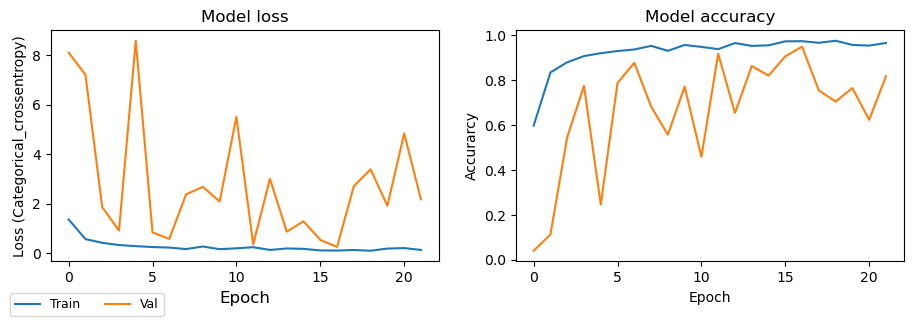

In [31]:
fig, axes = plt.subplots(ncols=2, figsize=(11,3))

axes[0].plot(hypermodel.history.history['loss'][:])
axes[0].plot(hypermodel.history.history['val_loss'][:])
axes[0].set_title('Model loss')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss (Categorical_crossentropy)')

axes[1].plot(hypermodel.history.history['accuracy'][:])
axes[1].plot(hypermodel.history.history['val_accuracy'][:])
axes[1].set_title('Model accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accurarcy')

axes[0].yaxis.set_tick_params(labelsize=10)
axes[1].yaxis.set_tick_params(labelsize=10)

fig.legend(labels=['Train', 'Val'], loc='upper left', ncol=2, fontsize=9,
           bbox_transform=fig.transFigure, bbox_to_anchor=(0.082, 0.025))

plt.show()

From the graphs above, we can see the validation loss is fluctuating. I'm not sure the actual reason for the problem, but there are some possibilities:
- The model is overfitting.
- The batch size is not optimal.
- The AlexNet architecture does not perform well on this problem.
- There are 19 classes, and some of the symbols are very similar, which makes the data less representative. 

<h4>Evaluate the model using test dataset</h4>

In [32]:
eval_result = hypermodel.evaluate(test)

16/16 [==============================] - 1s 26ms/step - loss: 2.1603 - accuracy: 0.8193


The accuracy is 81.93%. It is a fair model considering there are 19 classes to classify. However, I still want to see if there is another model to perform better. 

<h3>IV: Build a model using VGGNet19</h3>

In this section, I want to try a pre-trained model (VGGNet19) to see if it performs better than the previous model (AlexNet).

In [33]:
from keras.applications.vgg19 import VGG19

In [34]:
vgg19 = VGG19(include_top=False,
              weights='imagenet',
              input_shape=(224,224,3),
              pooling=None)

In [35]:
for layer in vgg19.layers:
    layer.trainable = False

In [67]:
# Instantiate the sequential model and add the VGG19 model: 
model = Sequential()
model.add(vgg19)

# Add the custom layers atop the VGG19 model: 
model.add(Flatten(name='flattened'))
model.add(Dropout(0.5, name='dropout'))
model.add(Dense(19, activation='softmax', name='predictions'))

In [68]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [69]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)
history = model.fit

model.fit(train, epochs=20, verbose=1, validation_data=val)

Epoch 1/20
107/107 [==============================] - 20s 177ms/step - loss: 0.7709 - accuracy: 0.7856 - val_loss: 0.2255 - val_accuracy: 0.9479
Epoch 2/20
107/107 [==============================] - 19s 176ms/step - loss: 0.1780 - accuracy: 0.9535 - val_loss: 0.1599 - val_accuracy: 0.9536
Epoch 3/20
107/107 [==============================] - 19s 176ms/step - loss: 0.0954 - accuracy: 0.9770 - val_loss: 0.1165 - val_accuracy: 0.9708
Epoch 4/20
107/107 [==============================] - 19s 176ms/step - loss: 0.0629 - accuracy: 0.9887 - val_loss: 0.0923 - val_accuracy: 0.9788
Epoch 5/20
107/107 [==============================] - 19s 176ms/step - loss: 0.0364 - accuracy: 0.9950 - val_loss: 0.0946 - val_accuracy: 0.9748
Epoch 6/20
107/107 [==============================] - 19s 176ms/step - loss: 0.0339 - accuracy: 0.9938 - val_loss: 0.0865 - val_accuracy: 0.9757
Epoch 7/20
107/107 [==============================] - 19s 176ms/step - loss: 0.0228 - accuracy: 0.9978 - val_loss: 0.0683 - val_ac

<h4>Plot the model loss and model accuracy</h4>

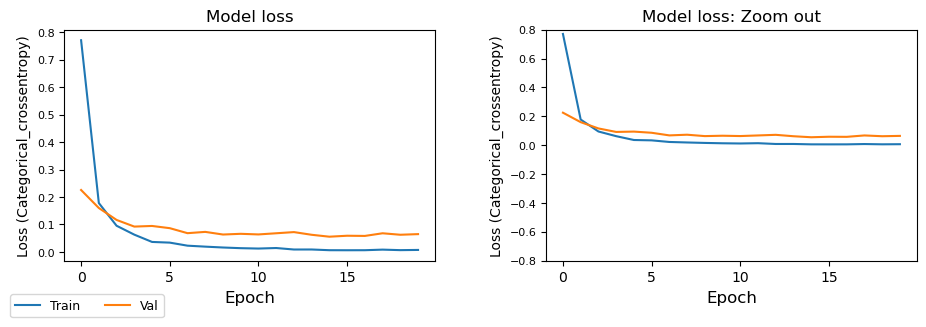

In [70]:
fig, axes = plt.subplots(ncols=2, figsize=(11,3))

for i in range(2):
    axes[i].plot(model.history.history['loss'][:])
    axes[i].plot(model.history.history['val_loss'][:])
    axes[i].set_xlabel('Epoch', fontsize=12)
    axes[i].set_ylabel('Loss (Categorical_crossentropy)')

axes[0].set_title('Model loss')
axes[1].set_title('Model loss: Zoom out')
axes[1].set_ylim([-0.8, 0.8])

axes[0].yaxis.set_tick_params(labelsize=8)
axes[1].yaxis.set_tick_params(labelsize=8)

fig.legend(labels=['Train', 'Val'], loc='upper left', ncol=2, fontsize=9,
           bbox_transform=fig.transFigure, bbox_to_anchor=(0.070, 0.02))
#plt.tight_layout()
fig.subplots_adjust(wspace=0.3)
plt.show()

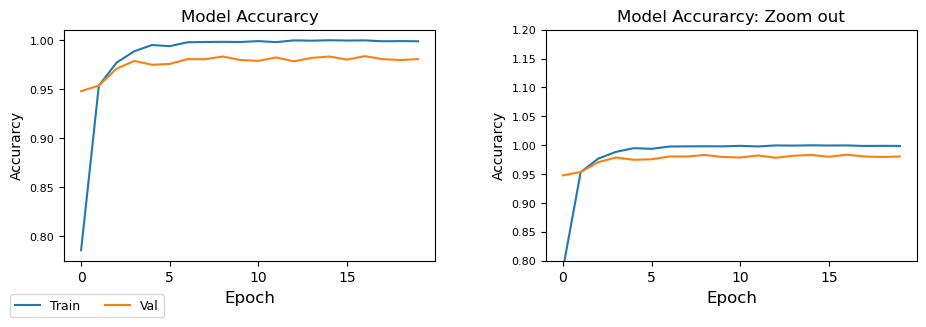

In [71]:
fig, axes = plt.subplots(ncols=2, figsize=(11,3))

for i in range(2):
    axes[i].plot(model.history.history['accuracy'][:])
    axes[i].plot(model.history.history['val_accuracy'][:])
    axes[i].set_xlabel('Epoch', fontsize=12)
    axes[i].set_ylabel('Accurarcy')

axes[0].set_title('Model Accurarcy')
axes[1].set_title('Model Accurarcy: Zoom out')
axes[1].set_ylim([0.8, 1.2])

axes[0].yaxis.set_tick_params(labelsize=8)
axes[1].yaxis.set_tick_params(labelsize=8)

fig.legend(labels=['Train', 'Val'], loc='upper left', ncol=2, fontsize=9,
           bbox_transform=fig.transFigure, bbox_to_anchor=(0.070, 0.02))
#plt.tight_layout()
fig.subplots_adjust(wspace=0.3)
plt.show()

I am impressed by the model. It shows high accuracy and low loss even from the beginning. Because of the complexity of VGGNet19 architecture, maybe there is no need to run many epochs to improve the model.

<h3>V: Evaluate the Model Using Test Dataset</h3>

In [72]:
eval_result = model.evaluate(test)

16/16 [==============================] - 6s 333ms/step - loss: 0.0794 - accuracy: 0.9774


The accuracy of this model is 97.74%, which is way better than the previous hypermodel (81.93%). VGGNet19 architecture is truly amazing.

<h4>Plot a Confusion Matrix</h4>

In [73]:
y_pred = model.predict(test)

16/16 [==============================] - 3s 153ms/step


In [74]:
#Convert the predition values into classes 
y_pred = np.argmax(y_pred, axis=1)
y_pred_classes =  [labels[e] for e in y_pred]
print('There are', len(y_pred_classes), 'elements in y_pred_classes.')

There are 1018 elements in y_pred_classes.


In [75]:
#Seperate y from test dataset
y_test = test.map(lambda x,y: y)
#Create a list to store the data
y_true = []
for element in y_test.as_numpy_iterator():
    y_true.extend(np.argmax(element, axis=1))

y_true_classes =  [labels[e] for e in y_true]
print('There are', len(y_true_classes), 'elements in y_true_classes.')

There are 1018 elements in y_true_classes.


In [76]:
#Create a confusion matrix using y_pred_classes and y-true_classes
from sklearn.metrics import confusion_matrix, classification_report
cf_mtx = confusion_matrix(y_true_classes, y_pred_classes)

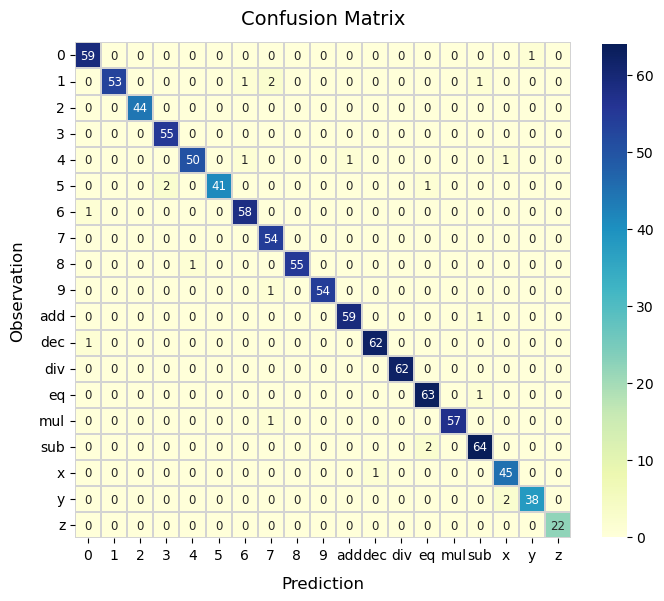

In [78]:
# plot the confusion matrix
import seaborn as sns

plt.figure(figsize=(8,8))
cm = cf_mtx
classes = labels

sns.heatmap(cm, annot=True, linewidth=0.1, linecolor='lightgray',
                annot_kws={"size":8.5,'fontstretch':'ultra-condensed', 'weight':'ultralight'}, fmt='', 
                cmap='YlGnBu', square=True,
                xticklabels=classes, yticklabels=classes, cbar_kws={'shrink':0.8})
plt.title('Confusion Matrix', fontsize=14, y=1.02)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10, rotation=0)
plt.ylabel('Observation', fontsize=12, labelpad=10)
plt.xlabel('Prediction', fontsize=12, labelpad=10)

plt.show()

From the confusion matrix above we can see that there are only few misclassifications in the test dataset, most of the images are classified perfectly.

<h4>Classification Report</h4>

In [79]:
#Show the classification report summary
print(classification_report(y_true_classes, y_pred_classes))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98        60
           1       1.00      0.93      0.96        57
           2       1.00      1.00      1.00        44
           3       0.96      1.00      0.98        55
           4       0.98      0.94      0.96        53
           5       1.00      0.93      0.96        44
           6       0.97      0.98      0.97        59
           7       0.93      1.00      0.96        54
           8       1.00      0.98      0.99        56
           9       1.00      0.98      0.99        55
         add       0.98      0.98      0.98        60
         dec       0.98      0.98      0.98        63
         div       1.00      1.00      1.00        62
          eq       0.95      0.98      0.97        64
         mul       1.00      0.98      0.99        58
         sub       0.96      0.97      0.96        66
           x       0.94      0.98      0.96        46
           y       0.97    

The classification report shows a very balanced result, with 98% accuracy. I am satisfied with this model.

<h3>VI: Save the Final Model and Test with My Own Handwriting</h3>

<h4>Save the Model</h4>

In [80]:
from tensorflow.keras.models import load_model
model.save(os.path.join('models','math_symbols_classifier.h5'))

<h4>Load the Model</h4>

In [81]:
#Load the model
my_model = load_model(os.path.join('models','math_symbols_classifier.h5'))

<h4>Try the Model Using My Own Handwritten Images</h4>

Since the dataset only have black and white, I want to see if the model can handle my handwriting with other colors as well. So I created some images randomly to see the results.

In [83]:
def load_images(folder):               # Path of folder (dataset)
    images=[]                           # list contatining  all images
    print('Loading images...')
    for filename in os.listdir(folder):
        print(filename)
        img = cv2.imread(folder+'/'+filename)  # reading image (Folder path and image name )
        img = cv2.resize(img, (224,224))  #Resize the image to input shape of the model
        #img = np.array(img)                #
        #img=img.flatten()                # Flatten image 
        images.append(img)               # Appending all images in 'images' list 
    return(images)

In [96]:
images = load_images('test images')

Loading images...
01.jpg
02.jpg
03.png
04.png
05.jpg
06.png
07.png
08.png


In [97]:
#Save the predited results into a list
pred_results=[]
predict_array = my_model.predict(np.asarray(images)/255)
predict_num = np.argmax(predict_array, axis=1)
predict_label =  [labels[e] for e in predict_num]
pred_results.extend(predict_label)

1/1 [==============================] - 0s 34ms/step


<h4>Plot the result</h4>

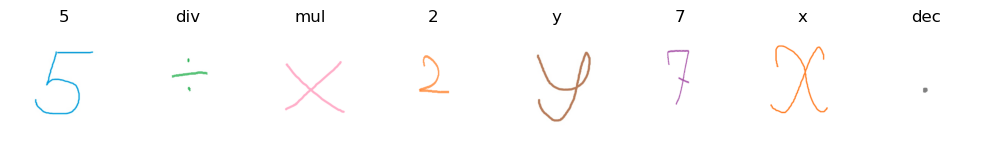

In [98]:
fig, ax = plt.subplots(ncols=len(images), figsize=(10,10))

for idx, img in enumerate(images):
    ax[idx].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax[idx].set_title(pred_results[idx])
    ax[idx].axis('off')

plt.tight_layout()

As the label shows, all my handwritten images are classified correctly with different colors. It is a successful model not only performs well with its own dataset samples, but can handle other images as well.

<h3>VII: Conclusion</h3>

For this project, I created two CNN models and evaluate the model with test data and my own handwriting. 
- The first model I used <b>AlexNet</b> and <b>Keras Tuner</b>.
    - The best activation function is 'relu' for dense layers.
    - The best learning rate is 0.001 for the optmizer Adam.
    - I also trained the model using more epochs with early stopping (end with 22 epochs). 
    - This model shows 81.93% accuracy with the test dataset. Although the accuracy is not bad, the validation loss fluctuates during training. 
- The second model I used <b>VGGNet19</b>.
    - This model performs better by showing 97.74% accuracy with its test dataset.
    - The confusion matrix shows only a few misclassifications.
    - The classification report shows 98% for all the performance metrics including precision, recall, f1-score, and accuracy. 
    - It also classified my 8 handwritten images perfectly.